In [1]:
# --- Using Monte-Carlo to find solutions within given uncertainty range,
# for a simple TB model

import numpy as np
import pandas as pd
import pyDOE as pyd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

beta  = [];                                                                # Infections per year, per infectious case: unspecified here, as we're going to calibrate it
gamma = [];                                                                # Rate of cure, through treatment or self-cure: unspecified here, as we're going to calibrate it
u     = 0.0826;                                                            # Hazard rate of reactivation from latent 'fast' infection
v     = 0.0006;                                                            # Hazard rate of reactivation from latent 'slow' infection
w     = 0.872;                                                             # Hazard rate of stabilising from latent 'fast' to 'slow' status
muTB  = 1/6;                                                               # Hazard rate of death from TB
mu    = 1/70;                                                              # Background mortality hazard


data_incd = [75,150];                                                      # Data for the range of possible values for incidence


beta_range  = [0,100];                                                     # Prior range for beta
gamma_range = [0.1,12];                                                    # Prior range for gamma 

# Take 1,000 random samples for beta and gamma, and simulate resulting 
# incidence with each one
nsam    = 1000;
ranges  = np.array([beta_range, gamma_range]).transpose();                                      # Arranged so that lower values are in first row, and upper values are in second row
samples = ranges[0,] + np.multiply((ranges[1,] - ranges[0,:]),pyd.lhs(2,nsam));    

accept = np.zeros(nsam);



In [2]:
def goveqs(y,t, beta, gamma, u, v, w, muTB, mu):

    # Function defining the governing equations (local gradient)
    # y:    state vector at time 't'
    # t:     time (not actually used in the current governing equations, but kept as placeholder)
    # out:   vector of first derivatives for each compartment

    # Initialise the output vector
    out = np.zeros(6);
    U  = y[0];
    Lf = y[1];
    Ls = y[2];
    I  = y[3];
    R  = y[4];
    J  = y[5];
    N  = U+Lf+Ls+I+R;

    # Set up the governing equations
    out[0] = -beta*U*I/N + mu*N + muTB*I - mu*U;                               # dU/dt
    out[1] = beta*U*I/N - (u + w + mu)*Lf;                                     # dLf/dt
    out[2] = w*Lf - (v + mu)*Ls;                                               # dLs/dt
    out[3] = u*Lf + v*Ls - (mu + muTB + gamma)*I;                              # dI/dt
    out[4] = gamma*I - mu*R;                                                   # dR/dt
    out[5] = u*Lf + v*Ls;                                                      # dJ/dt
    return out

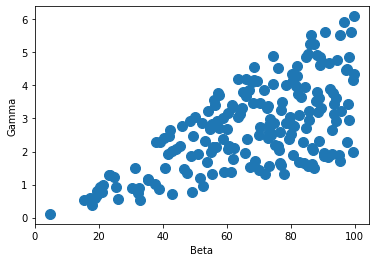

In [3]:
incd_sto = np.empty((500,nsam));
for ii in range(nsam):
    sam = samples[ii,];
    beta  = sam[0];
    gamma = sam[1];
    
    
    seed = 1e-6; init = [1-seed, seed, 0, 0, 0, 0]; # Introducing a perturbation ('seed') to the disease-free equilibrium
    geq = lambda y,t: goveqs(y,t, beta, gamma, u, v, w, muTB, mu);               # Function handle to goveqs, allowing us to fix model parameters when running the simulation
    soln = odeint(geq,init,np.arange(0, 500+1, 1));                                        # Simulating the epidemic for 500 years, to equilibrium
   
    soln_df = pd.DataFrame(soln, columns = ['U', 'Lf', 'Ls', 'I', 'R', 'J'])
    #Find the equilibrium incidence
    a=soln_df['J']
    tmp = np.multiply([x - a[i - 1] for i, x in enumerate(a) if i > 0],1e5);                                             # Note this only works when ensuring ODE is solved at annual timepoints
    incd=np.empty(nsam)
    incd[ii] = tmp[-1];
    
    incd_sto[:,ii] = tmp;
   
    # Check whether it falls within the range
    if incd[ii]>data_incd[0] and incd[ii]<data_incd[1]:
        accept[ii] = 1; 

# Extract the accepted values, and show a scatter plot
accepted_values = samples[accept==1,];
plt.plot(accepted_values[:,0], accepted_values[:,1], 'o', markersize=10);
#line.remove()
plt.xlabel('Beta');
plt.ylabel('Gamma');




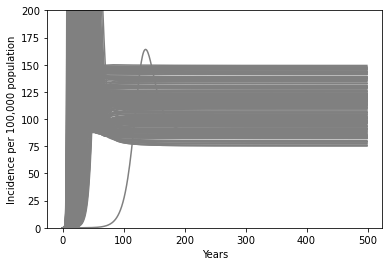

In [4]:
# Also, show the incidence curves superimposed, to show that their
# equilibra come within the stated range
plt.plot(incd_sto[:,accept==1], color=(0.5,0.5,0.5));
plt.ylim([0,200]);
plt.xlabel('Years');
plt.ylabel('Incidence per 100,000 population');